In [1]:
#pip install torch

In [2]:
#pip install torchvision numpy matplotlib

In [3]:
import torch
import torch.nn as nn
from torch.optim import SGD
from torch.optim import lr_scheduler
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy

/home/wes-237b/.local/lib/python3.6/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")


Download from www.di.ens.fr/~lelarge/MNIST.tar.gz

In [4]:
!ls MNIST

processed  raw


In [5]:
x, y = torch.load('/home/wes-237b/MNIST/MNIST/processed/training.pt')

In [6]:
x.shape

torch.Size([60000, 28, 28])

In [7]:
y.shape

torch.Size([60000])

torch.Size([28, 28])
tensor(4)


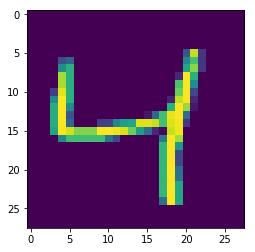

In [8]:
plt.imshow(x[2])
print(x[2].shape)
print(y[2])

# PyTorch Dataset Object

In [9]:
class CTDataset(Dataset):
    def __init__(self, filepath):
        self.x, self.y = torch.load(filepath)
        self.x = self.x / 255.
        self.y = F.one_hot(self.y, num_classes=10).to(float)
    def __len__(self): 
        return self.x.shape[0]
    def __getitem__(self, ix): 
        return self.x[ix], self.y[ix]

In [10]:
train_ds = CTDataset('/home/wes-237b/MNIST/MNIST/processed/training.pt')
test_ds = CTDataset('/home/wes-237b/MNIST/MNIST/processed/test.pt')

In [11]:
len(train_ds)

60000

In [12]:
train_ds[0][1]

tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=torch.float64)

In [13]:
xs, ys = train_ds[0:4]

In [14]:
ys.shape

torch.Size([4, 10])

# PyTorch DataLoader Object

We can then put the `Dataset` objects inside a `DataLoader` class. This is useful because we can specify a `batch_size`. Each iteration through the dataloader will yield a tensor where the first dimension is equal to the `batch_size`.

In [15]:
train_dl = DataLoader(train_ds, batch_size=5)

In [16]:
for x, y in train_dl:
    print(x.shape)
    print(y.shape)
    break

torch.Size([5, 28, 28])
torch.Size([5, 10])


Since the `batch_size` here is 5, and there are 60000 images, the length of the `DataLoader` object should be 12000.

In [17]:
len(train_dl)

12000

# Cross Entropy Loss

In [18]:
L = nn.CrossEntropyLoss()

# The Network

In [19]:
class MyNeuralNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.Matrix1 = nn.Linear(28**2,100)
        self.Matrix2 = nn.Linear(100,50)
        self.Matrix3 = nn.Linear(50,10)
        self.R = nn.ReLU()
    def forward(self,x):
        x = x.view(-1,28**2)
        x = self.R(self.Matrix1(x))
        x = self.R(self.Matrix2(x))
        x = self.Matrix3(x)
        return x.squeeze()

In [20]:
f = MyNeuralNet()

# Training

In [21]:
def train_model(dl, f, n_epochs=20):
    # Optimization
    opt = SGD(f.parameters(), lr=0.01)
    L = nn.CrossEntropyLoss()

    # Train model
    losses = []
    epochs = []
    for epoch in range(n_epochs):
        print(f'Epoch {epoch}')
        N = len(dl)
        for i, (x, y) in enumerate(dl):
            # Update the weights of the network
            opt.zero_grad() 
            loss_value = L(f(x), y) 
            loss_value.backward() 
            opt.step() 
            # Store training data
            epochs.append(epoch+i/N)
            losses.append(loss_value.item())
    return np.array(epochs), np.array(losses)

In [22]:
epoch_data, loss_data = train_model(train_dl, f)

Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19


In [24]:
epoch_data_avgd = epoch_data.reshape(20,-1).mean(axis=1)
loss_data_avgd = loss_data.reshape(20,-1).mean(axis=1)

Text(0.5,1,'Cross Entropy (avgd per epoch)')

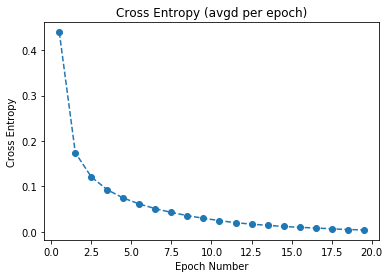

In [25]:
plt.plot(epoch_data_avgd, loss_data_avgd, 'o--')
plt.xlabel('Epoch Number')
plt.ylabel('Cross Entropy')
plt.title('Cross Entropy (avgd per epoch)')

Look at a sample image label $y$:

In [26]:
y_sample = train_ds[0][1]
y_sample

tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=torch.float64)

Look at sample prediction $\hat{y}$

In [27]:
type(train_ds[3][0])

torch.Tensor

In [28]:
train_ds[3][0].shape

torch.Size([28, 28])

In [29]:
train_ds[3][1].shape

torch.Size([10])

In [30]:
train_ds[3][1]

tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=torch.float64)

In [31]:
for i in range(28):
    print(torch.argmax(f(train_ds[i][0])))

tensor(5)
tensor(0)
tensor(4)
tensor(1)
tensor(9)
tensor(2)
tensor(1)
tensor(3)
tensor(1)
tensor(4)
tensor(3)
tensor(5)
tensor(3)
tensor(6)
tensor(1)
tensor(7)
tensor(2)
tensor(8)
tensor(6)
tensor(9)
tensor(4)
tensor(0)
tensor(9)
tensor(1)
tensor(1)
tensor(2)
tensor(4)
tensor(3)


In [32]:
!ls /home/wes-237b/MNIST/data/h_test

0.jpg  1.jpg  2.jpg  3.jpg  4.jpg  5.jpg  6.jpg  7.jpg	8.jpg  9.jpg


In [33]:
import cv2
import os
#IMG_DIR = "/home/wes-237b/MNIST/TestData"
#IMG_DIR = "/home/wes-237b/MNIST/data/train/4"
IMG_DIR = "/home/wes-237b/MNIST/data/h_test"

In [34]:

def get_tensor_from_test_img(img):
    img_arr = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
    img_arr = ~img_arr
    
    resized_img = cv2.resize(img_arr, (28, 28))
    resized_img = resized_img.astype(np.float32)
    resized_img_tensor = torch.from_numpy(resized_img)
    #print(resized_img_tensor)
    return resized_img_tensor

def get_tensor_from_test_dir(IMG_DIR):
    img_tensor_list = []
    for img in os.listdir(IMG_DIR):
        img_tensor_list.append(get_tensor_from_test_img(os.path.join(IMG_DIR, img)))
    return img_tensor_list


In [35]:
img_tensors = get_tensor_from_test_dir(IMG_DIR)

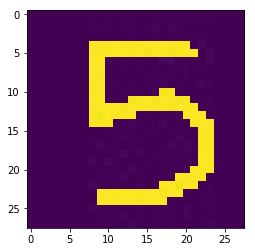

In [38]:
plt.imshow(img_tensors[0])

In [37]:
print(torch.argmax(f(img_tensors[0])))

tensor(5)


In [41]:
for img_tensor in img_tensors:
    print(torch.argmax(f(img_tensor)))

tensor(5)
tensor(6)
tensor(6)
tensor(0)
tensor(7)
tensor(3)
tensor(2)
tensor(9)
tensor(6)
tensor(2)


In [42]:
xs, ys = train_ds[0:2000]
yhats = f(xs).argmax(axis=1)

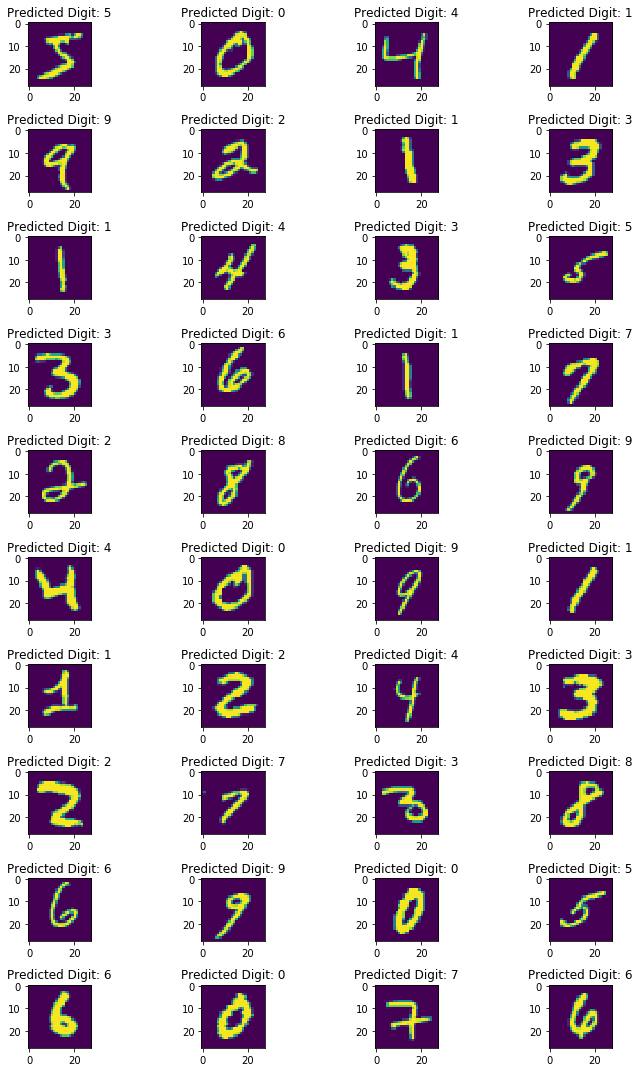

In [43]:
fig, ax = plt.subplots(10,4,figsize=(10,15))
for i in range(40):
    plt.subplot(10,4,i+1)
    plt.imshow(xs[i])
    plt.title(f'Predicted Digit: {yhats[i]}')
fig.tight_layout()
plt.show()

In [44]:
torch.save(f.state_dict(), '/home/wes-237b/MNIST/Pytorch_MNIST_Model.pt')

# Retraining

In [46]:
model_conv = MyNeuralNet()
model_conv.load_state_dict(torch.load('/home/wes-237b/MNIST/Pytorch_MNIST_Model.pt'))

<All keys matched successfully>

In [48]:
model_conv.Matrix3

Linear(in_features=50, out_features=10, bias=True)

In [51]:
model_conv

MyNeuralNet(
  (Matrix1): Linear(in_features=784, out_features=100, bias=True)
  (Matrix2): Linear(in_features=100, out_features=50, bias=True)
  (Matrix3): Linear(in_features=50, out_features=10, bias=True)
  (R): ReLU()
)

In [49]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [50]:
device

device(type='cpu')

In [ ]:
#Retraining

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


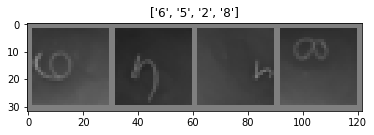

In [346]:


mean = np.array([0.5])#, 0.5, 0.5])
std = np.array([0.25])#, 0.25, 0.25])

data_transforms = {
    'train': transforms.Compose([
        transforms.Grayscale(1),
        transforms.Resize((28, 28)),
        transforms.RandomInvert(1),
        #transforms.RandomResizedCrop(28),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Grayscale(1),        
        transforms.Resize((28, 28)),
        transforms.RandomInvert(1),
        #transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

data_dir = '/home/wes-237b/MNIST/data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(class_names)


def imshow(inp, title):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))


# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])


def train_model(model, criterion, optimizer, scheduler, num_epochs=20):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    #print(inputs.shape)
                    #print(torch.mean(inputs, 1).shape)
                    #print(torch.squeeze(torch.mean(inputs, 1)).shape)
                    
                    outputs = model(inputs)
                    #outputs = model(torch.squeeze(torch.mean(inputs, 1)))
                    #print(outputs)
                    _, preds = torch.max(outputs, 1)
                    #preds = torch.max(outputs)
                    #print(preds)
                    #print(f'outputs : {outputs}')
                    #print(f'labels : {labels}')
                    loss = criterion(outputs, labels)
                    #print(1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        #print(2)
                        optimizer.zero_grad()
                        #print(3)
                        loss.backward()
                        #print(4)
                        optimizer.step()
                    

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


In [347]:
num_ftrs = model_conv.Matrix3.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_conv.Matrix3 = nn.Linear(num_ftrs, 10)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = SGD(model_conv.parameters(), lr=0.001)

# StepLR Decays the learning rate of each parameter group by gamma every step_size epochs
# Decay LR by a factor of 0.1 every 7 epochs
# Learning rate scheduling should be applied after optimizer’s update
# e.g., you should write your code this way:
# for epoch in range(100):
#     train(...)
#     validate(...)
#     scheduler.step()

step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model_conv = train_model(model_conv, criterion, optimizer, step_lr_scheduler, num_epochs=20)

Epoch 0/19
----------
train Loss: 3.3506 Acc: 0.0690
val Loss: 2.7078 Acc: 0.0667

Epoch 1/19
----------
train Loss: 2.5370 Acc: 0.1034
val Loss: 2.3879 Acc: 0.0333

Epoch 2/19
----------
train Loss: 2.4296 Acc: 0.1207
val Loss: 2.3799 Acc: 0.1000

Epoch 3/19
----------
train Loss: 2.4098 Acc: 0.0862
val Loss: 2.3747 Acc: 0.0333

Epoch 4/19
----------
train Loss: 2.4378 Acc: 0.0948
val Loss: 2.3762 Acc: 0.0667

Epoch 5/19
----------
train Loss: 2.4363 Acc: 0.0690
val Loss: 2.3982 Acc: 0.1000

Epoch 6/19
----------
train Loss: 2.4894 Acc: 0.0431
val Loss: 2.3852 Acc: 0.1000

Epoch 7/19
----------
train Loss: 2.3258 Acc: 0.1379
val Loss: 2.3679 Acc: 0.1333

Epoch 8/19
----------
train Loss: 2.3014 Acc: 0.1379
val Loss: 2.3632 Acc: 0.0667

Epoch 9/19
----------
train Loss: 2.3198 Acc: 0.1207
val Loss: 2.3630 Acc: 0.1333

Epoch 10/19
----------
train Loss: 2.3132 Acc: 0.1293
val Loss: 2.3623 Acc: 0.1333

Epoch 11/19
----------
train Loss: 2.3019 Acc: 0.1379
val Loss: 2.3629 Acc: 0.1333

Ep

In [330]:
model_conv

MyNeuralNet(
  (Matrix1): Linear(in_features=784, out_features=100, bias=True)
  (Matrix2): Linear(in_features=100, out_features=50, bias=True)
  (Matrix3): Linear(in_features=50, out_features=10, bias=True)
  (R): ReLU()
  (fc): Linear(in_features=50, out_features=10, bias=True)
)

In [349]:
import cv2
import os
#IMG_DIR = "/home/wes-237b/MNIST/TestData"
IMG_DIR = "/home/wes-237b/MNIST/data/train/5"


def get_tensor_from_test_img(img):
    img_arr = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
    img_arr = ~img_arr
    
    resized_img = cv2.resize(img_arr, (28, 28))
    resized_img = resized_img.astype(np.float32)
    resized_img_tensor = torch.from_numpy(resized_img)
    #print(resized_img_tensor)
    return resized_img_tensor

def get_tensor_from_test_dir(IMG_DIR):
    img_tensor_list = []
    for img in os.listdir(IMG_DIR):
        img_tensor_list.append(get_tensor_from_test_img(os.path.join(IMG_DIR, img)))
    return img_tensor_list

img_tensors = get_tensor_from_test_dir(IMG_DIR)

for img_tensor in img_tensors:
    print(torch.argmax(model_conv(img_tensor)))


tensor(8)
tensor(8)
tensor(6)
tensor(6)
tensor(8)
tensor(6)
tensor(8)
tensor(6)
tensor(6)
tensor(6)
tensor(6)
tensor(6)
